In [1]:
import pandas as pd
import csv
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.stem import WordNetLemmatizer

In [2]:
import torch
from transformers import BertTokenizer, BertModel

In [3]:
data = pd.read_csv('publ.csv')
data.sample(3)

<ipython-input-3-47bcf7cd181f>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('publ.csv')


,publ_id,publ_name,year,doi,annotation,geo_name,collect_name,collect_type,author_affs,author_ids
72234,1040219,EVOLUTION OF THE FIELD OF DISTRIBUTED DEFECTS ...,2022,https://doi.org/10.18287/2541-7525-2022-28-1-2...,The article discusses the mathematical modelin...,NaN,NaN,NaN,Institute for Problems in Mechanics,1003774; 1003771
66406,1034391,Speed-gradient entropy maximization in networks,2016,https://doi.org/10.1109/norbert.2016.7547461,Dynamics of networks which tend to reach conse...,NaN,NaN,NaN,Institute of Problems of Mechanical Engineering,1001323; 1004588; 1048941
29352,29892,Управление процессом генерации энергии транспо...,2022,NaN,В данной работе рассматривается задача управле...,Москва,NaN,NaN,ИПУ РАН,85


**Описание признаков:**

publ_id	- Уникальный идентификатор публикации.

year -	Год публикации.

doi	- Digital Object Identifier Уникальный идентификатор для электронных документов.

annotation -	Аннотация или краткое содержание публикации. Это текстовое поле может содержать основные идеи или выводы работы.

geo_name -	Географическое название, связанное с публикацией.

collect_name -	Название коллекции, к которой принадлежит публикация.

collect_type -	Тип коллекции, например, журнал, конференция, книга и т.д. Это помогает классифицировать тип публикации.

author_affs	- Аффилиации авторов.

author_ids - Идентификаторы авторов.

Часть признаков не нужны в исследовании, поэтому удалим их.

In [4]:
data = data.drop(['doi','collect_name','author_affs','author_ids'], axis=1)

Посмотрим содержание пустых строк в датасете

<Axes: >

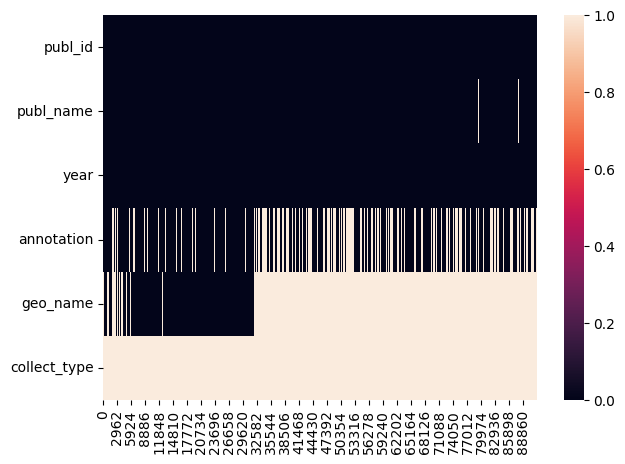

In [5]:
plt.figure(figsize=(7,5))
sns.heatmap(data.isna().transpose())

Видим, что много пустых значений в geo_name и collect_type, поэтому также удалим эти столбцы. Дополнительно удалим строки не содержашие аннотации и название публикации.

In [6]:
data = data.drop(['geo_name','collect_type'], axis=1)

In [7]:
data = data.dropna()

Разделим датасет на два: статьи на русском и английском языках. Для этого создадим дополнительный признак, содержащий информацию о языке.

In [8]:
def is_russian(text):
    return bool(re.search(r'[а-яА-Я]', text))

In [9]:
data['language'] = data['publ_name'].apply(lambda x: 'ru' if is_russian(x) else 'en')

data_ru = data[data['language'] == 'ru']
data_en = data[data['language'] == 'en']

In [10]:
data_ru.shape

(23483, 5)

In [11]:
data_en.shape

(42410, 5)

In [12]:
data_ru # название и аннотация на разных языках...

,publ_id,publ_name,year,annotation,language
0,1,Методы и средства волнового фитоуправления в б...,2005,Рассматриваются методы и средства волнового фи...,ru
1,2,Метод динамической компенсации в задаче оценив...,2005,В докладе рассматривается задача стабилизации ...,ru
2,3,Управление электромеханическими системами в ус...,2005,Рассматривается задача управления угловым поло...,ru
4,5,Задача стабилизации линейных систем с сигмоида...,2005,Предложена декомпозиционная процедура синтеза ...,ru
5,6,Скользящий электропривод постоянного тока,2005,В работе рассмотрена задача позиционирования д...,ru
...,...,...,...,...,...
91632,1059617,Особенности движения шагающей машины с поворот...,2013,Kinematics mathematical model of walking machi...,ru
91633,1059618,Экспериментальные исследования знакопеременног...,2011,Such operating mode of deep-well pump installa...,ru
91695,1059680,СинтеЗ классификатороВ дифференциальноЙ дИагно...,2011,In the paper classifiers for light form of coa...,ru
91701,1059686,Адаптивная система классификаторов МГУА,2014,"It is shown that the self-organization models,...",ru


Найдем самые популярные темы исследования для определения целевой функции. Это можно сделать частотным методом, выбрав самые встречающиеся темы из названия статей.

In [13]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

In [14]:
 nltk.download('stopwords')
 nltk.download('punkt')
 nltk.download('wordnet')
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
titles = data_ru['annotation']

processed_titles = titles.apply(preprocess_text)

all_words = ' '.join(processed_titles).split()

bigrams = ngrams(all_words, 2)
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Самые популярные темы исследования:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

Самые популярные темы исследования:
of the: 3398
in the: 1328
систем управления: 753
on the: 748
рассматривается задача: 688
системы управления: 665
принятия решений: 653
to the: 542
решения задачи: 534
of a: 526


In [16]:
bigrams = ngrams(all_words, 3)
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Самые популярные темы исследования:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

Самые популярные темы исследования:
the problem of: 252
поддержки принятия решений: 224
based on the: 182
the result of: 154
беспилотных летательных аппаратов: 141
линейных матричных неравенств: 129
a well a: 129
the basis of: 126
on the basis: 120
the use of: 120


In [17]:
bigrams = ngrams(all_words, 4)
bigram_counts = Counter(bigrams)

most_common_bigrams = bigram_counts.most_common(10)
print("Самые популярные темы исследования:")
for bigram, count in most_common_bigrams:
    print(f"{' '.join(bigram)}: {count}")

Самые популярные темы исследования:
on the basis of: 119
пульсового сигнала лучевой артерии: 80
it is shown that: 71
студентов высших учебных заведений: 61
системы поддержки принятия решений: 54
студентов преподавателей инженеров научных: 49
преподавателей инженеров научных работников: 49
is based on the: 46
the basis of the: 45
the result of the: 43


In [18]:
def recommend_articles(user_preferences):
    # Фильтрация статей по предпочтениям пользователя
    recommended = data[data['annotation'].str.contains('|'.join(user_preferences), case=False)]

    # Сортировка по популярности (можно добавить больше критериев)
    recommended = recommended.sort_values(by='year', ascending=False)  # или другой признак
    return recommended[['publ_id', 'publ_name', 'year']]

In [19]:
# Числовые признаки
num_cols = [
    'publ_id',
    'year'
]

# Категориальные признаки
cat_cols = [
    'publ_name',
    'annotation',
    'language'
]

feature_cols = num_cols + cat_cols
target_col = '?'

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess the 'annotation' column
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
data_small = data_en[:][:10000]
tfidf_matrix = tfidf_vectorizer.fit_transform(data_small['annotation'])

# Combine with other features (e.g., year)
# Assuming 'year' is already numeric; if not, you may need to encode it
features = pd.DataFrame(tfidf_matrix.toarray())
#features['year'] = data_en['year'].astype(str)

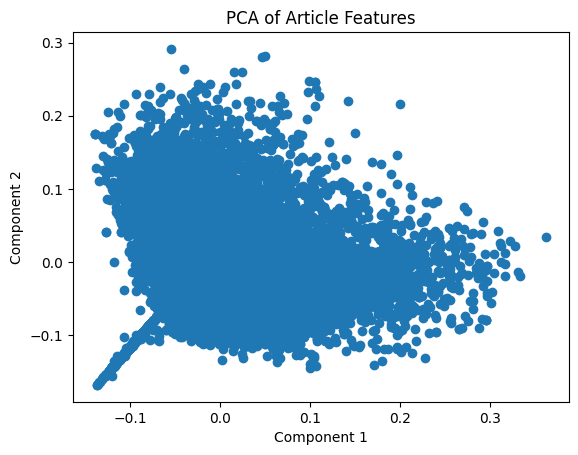

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

# Visualize the reduced features
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.title('PCA of Article Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [36]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
num_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data_small['cluster'] = kmeans.fit_predict(features)

# Display cluster assignments
print(data_small[['publ_id', 'publ_name', 'cluster']])

       publ_id                                          publ_name  cluster
3            4   VSS Error Feedback Regulation for Linear Systems        3
7            8  Direct Synthesis of Sliding Modes Identifier f...        3
8            9    On Stabilization Problem for Non-Linear Systems        3
15          16            Controlling Chaos by Predictive Control        3
57          58  Voting Strategies in a Stochastic Environment:...        4
...        ...                                                ...      ...
36694  1004679  Classification of Aerial Manipulation Systems ...        3
36701  1004686  Fermilab Testbeam Facility Annual Report – FY ...        4
36702  1004687  Automatic fingersign-to-speech translation system        4
36703  1004688  Trends in Development of UAV-UGV Cooperation A...        4
36704  1004689  Multimodal Synthesizer for Russian and Czech S...        0

[10000 rows x 3 columns]


In [40]:
def recommend_articles(article_id, num_recommendations=5):
    # Find the cluster of the given article
    cluster_id = data_small.loc[data_small['publ_id'] == article_id, 'cluster'].values[0]

    # Recommend articles from the same cluster
    recommendations = data_small[data_small['cluster'] == cluster_id].sample(num_recommendations)
    return recommendations[['publ_id', 'publ_name']]

# Example usage
some_article_id = 4
print(recommend_articles(some_article_id))

       publ_id                                          publ_name
31013    31583  Synthesis of a Discontinuous Control Law for a...
28462    28990  Suboptimal Control of Nonlinear Dynamic System...
21722    21888  Second order conditions in optimal control pro...
34794  1002779  Feedback Optimality Conditions with Weakly Inv...
15344    15469  Ellipsoidal motions for applied control: from ...


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Load pre-trained model tokenizer (vocabulary) for Russian
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Load pre-trained model for Russian
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')


# Example input text
texts = np.array(data_ru['publ_name'][:1000])

# Prepare inputs and get embeddings
embeddings = []

for text in texts:
    # Encode the text using the BERT tokenizer
    inputs = tokenizer(text, return_tensors='pt')

    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings for the first token ([CLS] token)
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()  # Shape: (1, hidden_size)
    embeddings.append(cls_embedding)

# Convert embeddings to a numpy array
embeddings = np.vstack(embeddings)

# Reduce dimensionality using PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Create a scatter plot of the reduced embeddings
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

plt.title('BERT Embeddings Visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()